# Single Cell Clone Velocities

In [10]:
import pandas as pd
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
exec(open('../settings.py').read(), globals())

## Trajectories

In [11]:
L0 = 800.0

In [12]:
clone_trajectories = pd.read_csv('../../data/clone_trajectories.csv')

In [13]:
clone_trajectories.head()

,ID,time,pos
0,1,0,-380.0
1,1,1,-372.0
2,1,2,-257.0
3,1,4,-115.0
4,1,5,-108.0


The number of trajectories used for the analysis is:

In [14]:
len(clone_trajectories['ID'].unique())

18

### Plot trajectories

In [15]:
cmap = mpl.colors.LinearSegmentedColormap.from_list('from_list',\
                                                    [(0, colorcycle[2]), (0.2, colorcycle[2]), (1.0, colorcycle[6])])
cmap = plt.get_cmap('jet')

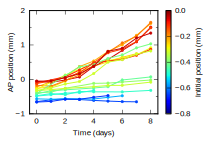

In [57]:
pos0 = clone_trajectories.query('time == 0')['pos']
norm = plt.Normalize(-L0 / 1000.0, 0.0)
# norm = plt.Normalize(pos0.min() / 1000.0, 0.0)
# cmap = plt.get_cmap('jet')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# fake up the array of the scalar mappable. Urgh...
sm._A = []

fig, ax = plt.subplots(1, figsize = (73.0 / 25.4, 47.0 / 25.4))
fig.patch.set_alpha(1.0)
for ID, IDdata in clone_trajectories.groupby('ID'):
    color = cmap(norm(float(IDdata.query('time == 0')['pos']) /1000.0))
    ax.plot(IDdata['time'], IDdata['pos'] / 1000.0, color = color, marker = '.', ms = 5)
    
ax.set_xlim(-0.5, 8.5)
ax.set_ylim(-1.0, 2.0)
ax.set_yticks(sp.arange(-1.0, 2.1, 1.0))
ax.set_yticks(sp.arange(-0.5, 1.6, 1.0), minor=True)
ax.tick_params(axis='both', which='major')

ax.set_xlabel('Time (days)')
ax.set_ylabel('AP position (mm)')

    
cbar = plt.colorbar(sm, ax = ax, ticks = sp.linspace(-L0/1000.0, 0, 5))
cbar.set_label('Intitial position (mm)', labelpad=9)
plt.savefig('../../figure_plots/Fig2_clone_trajectories.svg')
plt.show()

In [41]:
p.line?

In [50]:
from bokeh.plotting import figure, output_notebook, show
output_notebook()
TOOLS = 'hover'
p = figure(tools = TOOLS)
for ID, IDdata in clone_trajectories.groupby('ID'):
    color = cmap(norm(float(IDdata.query('time == 0')['pos']) /1000.0))
    p.line(IDdata['time'], IDdata['pos'] / 1000.0, color = mpl.colors.rgb2hex(color), name = "ID_{}".format(ID))
show(p)

Loading BokehJS ...

In [56]:
clone_trajectories.query('time == 4').sort_values('pos')

,ID,time,pos
95,fa05,4,-611.0
107,fa11,4,-569.0
114,fa12,4,-519.0
88,fa01,4,-361.0
103,fa10,4,-321.0
10,3,4,-250.0
17,4,4,-212.0
3,1,4,-115.0
33,8,4,170.0
57,20,4,378.0


ID 8 seems to be a good candidate for showing a represantative image in Fig. 2I.

## Velocities

In [184]:
def velocities(binsize, mintime=0, maxtime=8, clone_trajectories=clone_trajectories):
    clone_trajectories = clone_trajectories.query('@mintime <= time <= @maxtime').copy()
    
    clone_trajectories['bin'] = (clone_trajectories['pos'] / binsize).round() * binsize

    def linregress_v(group):
        if len(group) > 1:
            v = sp.polyfit(group['time'], group['pos'], 1)[0]
        else:
            v = sp.nan
        return v

    clone_velocities = pd.DataFrame(clone_trajectories.groupby(['ID', 'bin']).apply(linregress_v).dropna()).reset_index()
    clone_velocities.columns = ['ID', 'pos', 'v']
    meanclone_velocity = clone_velocities[['pos', 'v']].groupby('pos').filter(lambda x: len(x) > 2).groupby('pos').agg(['mean', 'sem'])
    meanclone_velocity.columns = meanclone_velocity.columns.droplevel()
    meanclone_velocity = meanclone_velocity.reset_index()

    return clone_velocities, meanclone_velocity




In [185]:
clone_velocities, meanclone_velocity = velocities(L0)

In [186]:
clone_velocities.to_csv('../lg_model/clone_velocities.csv', index = False)

Plot the mean clone velocity

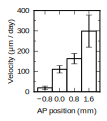

In [187]:
fig, ax = plt.subplots(figsize = (30.0 / 25.4, 37.0 / 25.4))
fig.patch.set_alpha(1.0)

# ax.errorbar(meanclonespeed['bin'], meanclonespeed['mean'], meanclonespeed['sem'], marker = 'o', color = 'black')
width = L0 / 1000.0
ax.bar((meanclone_velocity['pos'] / 1000.0- 0.5 * width), meanclone_velocity['mean'], 
       width = width, yerr = meanclone_velocity['sem'], 
       color = 'white', ecolor = 'black')

ax.set_xlim(-1.4, 2.2)
ax.set_xticks([-0.800, 0, 0.800, 1.600])
ax.set_ylim(0, 400)
ax.set_yticks(sp.arange(0, 401, 100))
ax.set_yticks(sp.arange(50, 401, 100), minor = True)

ax.tick_params(axis='both', which='major')

ax.set_xlabel('AP position (mm)')
ax.set_ylabel(u'Velocity (μm / day)', labelpad = 8)
plt.savefig('../../figure_plots/Fig2_clone_velocities.svg')
plt.show()

Clone velocity at -800 $\mu m$ is not significantly different from 0:

In [188]:
meanclone_velocity

,pos,mean,sem
0,-800.0,19.681429,8.545082
1,-0.0,110.894027,18.073999
2,800.0,163.314286,25.605620
3,1600.0,299.000000,78.924014


In [189]:
sp.stats.ttest_1samp(clone_velocities.query('pos == -@L0')['v'], 0)

Ttest_1sampResult(statistic=2.3032463061251724, pvalue=0.082643447508370674)